In [26]:
# Get the length of the ects-fiches of our university site (in order to find empty or almost empty fiches and see which faculty has the longest ects-fiches)
import requests
import re

from bs4 import BeautifulSoup
from tqdm import tqdm
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as xl

from pprint import pprint


# Get a list containing all trajectories of our university site
def get_trajectories():
    # Deze functie gaat naar volgende url:
    #  https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/?f=23%2C114%2C124
    # en probeert een lijst te maken van alle opleidingen op deze pagina

    #  Note: f=124 means only "Academische opleidingen", 114 for "Master" and 23 for bachelor
    # Krijg de inhoud van de site
    html = requests.get(
        'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/?s=16&lang=nl&f=23%2C114%2C124').text

    # Zet de inhoud om in een object waarmee ik makkelijk van het ene naar het andere element kan gaan
    parsed_html = BeautifulSoup(html, features="lxml")
    # Krijg het html deel dat de lijst van alle vakken bevat
    courses_list_html = parsed_html.find(class_="listCourses")
    # Iedere opleiding zit in een kaartje met klasse "wrap", dus zoek al deze kaartjes (en dus alle opleidingen)
    courses_list_html_objs = courses_list_html.find_all(class_="wrap")

    # Maak een lijst aan waarin ik alle opleidingen zal opslaan
    trajectories = []

    # Ga door alle opleidingen heen
    for course in courses_list_html_objs:
        # Krijg de url van de opleiding
        url = course["href"]

        # Op basis van de url kan je bepalen of het engels of nederlands is
        language = "nl" if url.startswith("/nl/") else "en"
        # Krijg de 'slug' van de opleiding (die later gebruikt wordt om de url van de ects-fiche te maken)
        # e.g. slug = "research-master-philosophy"
        course_slug = url.split("/")[-2]

        # get the degrees (master and/or bachelor)
        degrees_html = course.find_all("div", class_="value")[1]
        degrees_objs = degrees_html.find_all("li")
        degrees = list([degree.text.lower() for degree in degrees_objs])

        # Voeg de verzamelde informatie toe aan de lijst met alle vakken
        trajectories.append({"language": language, "slug": course_slug, "degrees": degrees})

    return trajectories


def get_courses(url):
    # Gegeven een url waarop het studieprogramma staat, krijg je een lijst met alle vakken van dit studieprogramma
    # (en wat extra info over die vakken)
    # url: study programme url,
    #  e.g. https://www.uantwerpen.be/en/study/programmes/all-programmes/research-master-philosophy/study-programme/
    try:

        # Laad de pagina zelf
        html = requests.get(url)

        # Controleer of de pagina succesvol geladen is
        if html.status_code != 200:
            print(f"Error getting {url}")
            return []

        # Zet de inhoud om in een object waarmee ik makkelijk van het ene naar het andere element kan gaan
        html = html.text
        parsed_html = BeautifulSoup(html, features="lxml")

        # Krijg een html object dat enkel de vakken van het meest recente jaar bevat
        current_year = parsed_html.find("section",
                                        class_="programmes")  # first find is the newest year, use find_all and an index to go to another year

        # Krijg de titels van alle vakken
        course_title_html_obj = current_year.find_all("h5")

        # Geef een waarschuwing als er geen vakken gevonden zijn
        if len(course_title_html_obj) == 0:
            print(f"Warning: no courses found for {url}")

        # Maak een lijst met extra info per vak
        courses = []
        for course in course_title_html_obj:
            # De url waar de ects fiche gevonden kan worden
            course_href = course.find("a")["href"]
            url_ects_fiche = f"https://www.uantwerpen.be/ajax/courseInfo{course_href}"

            # Op basis van deze url kan er extra info uitgehaald worden (bv. de faculteit kan uit de vakcode in de url
            # gehaald worden)

            course_info = {
                "year": course_href[4:8],
                "id": course_href[9:19],
                "href": course_href,
                "code": course_href[9:13],
                "faculty": course_href[13:16],
                "course": course_href[16:19],
                "name": course.text,
                "page": parsed_html.title.string,
                "url_study_programme": url,
                "url_ects_fiche": url_ects_fiche
            }

            courses.append(course_info)
        return courses

    except Exception as e:
        # Print een error moest er iets mislopen
        print(f"Error: {e}, {url}")
        return []


def is_ok(url):
    # Kijk of een url succesvol geladen kan worden
    return requests.get(url).status_code == 200

def contains_studieprogramma(url):
    html = requests.get(url)

    if html.status_code != 200:
        print(f"Error getting {url}")
        return False

    html = html.text
    parsed_html = BeautifulSoup(html, features="lxml")

    try:
        current_year = parsed_html.find("section",
                                        class_="programmes")
        return current_year is not None
    except:
        return False
     

def expand_urls(url):
    try:
        if contains_studieprogramma(url):
            return [url]
        
        # Geen studieprogramma gevonden op deze pagina. Zoek naar alle subpagina's die dit wel mogelijks hebben
        #         <li class="active">
        # 				<a href="/nl/studeren/aanbod/alle-opleidingen/rechten-studeren/master/studieprogramma/">Studieprogramma</a>														
        # <div class=" sub">
        # 		<ul class="active">
        # 																	<li>
        # 				<a href="/nl/studeren/aanbod/alle-opleidingen/rechten-studeren/master/studieprogramma/master-in-de-rechten/">Master in de rechten</a>							</li>
        # 																	<li>
        # 				<a href="/nl/studeren/aanbod/alle-opleidingen/rechten-studeren/master/studieprogramma/master-fiscaal-recht/">Master in de rechten: fiscaal recht</a>							</li>
        # 																	<li>
        # 				<a href="/nl/studeren/aanbod/alle-opleidingen/rechten-studeren/master/studieprogramma/master-of-laws/">Master of Laws</a>							</li>
        # 			</ul>
        # 	</div>

        # Find all a tags with text "Studieprogramma"
        studieprogramma_links = [a for a in BeautifulSoup(requests.get(url).text, features="lxml").find_all("a") if a.text == "Studieprogramma"]
        if len(studieprogramma_links) == 0:
            print(f"Error: no studieprogramma links found for {url}")
            return []
        
        # Get all hrefs of the subpages
        subpages_li = studieprogramma_links[0].parent.find("ul", class_="active").find_all("li")
        subpages = [li.find("a")["href"] for li in subpages_li]
        return [f"https://www.uantwerpen.be{subpage}" if "www.uantwerpen.be" not in subpage else subpage for subpage in subpages]
        

            

    except Exception as e:
        print(f"Error getting {url}: {e}")
        return []




def fetch_course_info(trajectories):
    # Gegeven een lijst met alle opleidingen (verkregen met de get_trajectories functie),
    #  krijg je een lijst met alle vakken van alle opleidingen
    all_courses = []
    num_success = 0  # number of successful requests
    num_total = 0  # totaal aantal vakken

    # trajectories = trajectories[:3]  # Work with a shorter list for debugging, this line should be commented out

    # Itereer over alle opleidingen
    for trajectory in tqdm(trajectories):

        degrees = trajectory["degrees"]
        slug = trajectory["slug"]

        # Bekijk de master en bachelor apart
        for degree in degrees:

            # Het totaal aantal opleidingen
            num_total += 1

            # Zoek de url waar het studieprogramma staat (door een paar url's te proberen)
            if trajectory["language"] == "nl":
                url1 = f"https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/{slug}/{degree}/studieprogramma/"
                url2 = f"https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/{slug}/over-de-{degree}/studieprogramma/"
                url3 = f"https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/{slug}/studieprogramma/"
                if is_ok(url1):
                    url = url1
                elif is_ok(url2):
                    url = url2
                elif is_ok(url3):
                    url = url3
                else:
                    # Indien geen url gevonden is voor dit vak, print een error en ga verder naar het volgende vak
                    print(f"Error: no url found for {slug} {degree}, {url1}, {trajectory['language']}")
                    continue
            else:
                # e.g.
                # https://www.uantwerpen.be/en/study/programmes/all-programmes/epidemiology/about-the-programme/study-programme/
                # https://www.uantwerpen.be/en/study/programmes/all-programmes/research-master-philosophy/study-programme/
                # https://www.uantwerpen.be/en/study/programmes/all-programmes/master-biology/study-programme/
                url1 = f"https://www.uantwerpen.be/en/study/programmes/all-programmes/{slug}/study-programme/"
                url2 = f"https://www.uantwerpen.be/en/study/programmes/all-programmes/{slug}/about-the-programme/study-programme/"
                url3 = f"https://www.uantwerpen.be/en/study/programmes/all-programmes/{degree}-{slug}/study-programme/"
                if is_ok(url1):
                    url = url1
                elif is_ok(url2):
                    url = url2
                else:
                    # Indien geen url gevonden is voor dit vak, print een error en ga verder naar het volgende vak
                    print(f"Error: no url found for {slug} {degree}, {url1}, {trajectory['language']}")
                    continue

            for single_url in expand_urls(url):
                try:
                    # Verzamel een lijst met alle vakken van deze opleiding
                    traj_courses = get_courses(single_url)

                    # Als er vakken gevonden zijn, hebben we succesvol het studieprogramma (en de vakken)
                    # van deze opleiding kunnen vinden
                    if len(traj_courses) > 0:
                        num_success += 1

                    # Kijk of de gegeven opleiding al in onze lijst met alle opleidingen zit
                    # indien niet, voeg hem dan toe aan de lijst met alle vakken
                    # indien deze er wel al inzit, is dit waarschijnlijk een vak overlappend met een andere opeiding
                    for course in traj_courses:
                        # Kijk of hij al in de lijst met alle vakken zit
                        if any(course["id"] in c["id"] for c in all_courses):
                            # course already added (probably overlap with another trajectory)
                            continue

                        # Indien niet, voeg het vak toe aan de lijst met alle vakken
                        all_courses.append(course)
                except Exception as e:
                    # Print een error moest er iets mislopen
                    print(f"Error: {e}, {single_url}")
                    continue

    # Toon in de output hoeveel opleidingen succesvol gevonden zijn
    print(f"Success: {num_success}/{num_total}")

    return all_courses


def load_pickle_or_get_from_function(filename, function, *args, **kwargs):
    # Een hulp functie om te zorgen dat ik niet altijd alles opnieuw van de site moet halen
    # Na het halen van info van de site, slaat dit de gevonden info lokaal op (in een 'pickle' bestand)
    # Indien het pickle bestand al bestaat, wordt deze geladen in plaats van opnieuw de info van de site te halen
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        result = function(*args, **kwargs)
        # Skipping write to picle because max recursion depth error
        # with open(filename, 'wb') as f:
        #     pickle.dump(result, f)
        return result


def get_ects_section(parsed_ects_html, section_number):
    # Gegeven een ects fiche html object
    # Geeft dit de inhoud van een bepaalde sectie terug

    # e.g. section 6 is assessment criteria
    completed_sections = parsed_ects_html.find_all("div", class_="main")
    if len(completed_sections) < section_number:
        return ""
    return completed_sections[section_number - 1].text


def get_courses_info(courses):
    # Gegeven een lijst met alle vakken (verkregen met de fetch_course_info functie),
    # deze lijst bevat al oppervlakkige info, maar met deze functies wordt per vak de ects fiche geladen en
    # wordt er extra info toegevoegd aan de vakken
    for course in tqdm(courses):
        try:
            # Laad de ects fiche van dit vak
            url = course["url_ects_fiche"]
            request = requests.get(url)

            # Statuscode van de site te laden (200 betekend succesvol geladen, 404 betekent dat er geen ects fiche is)
            status_code = request.status_code
            # Sla deze statuscode op in het vak (aangezien het belangrijk is om te weten dat een ects fiche niet gevonden kan worden)
            course["ects_status_code"] = status_code

            # Krijg de inhoud van de site zelf en zet deze om naar een html object waar we mee kunnen werken
            html = request.text
            parsed_html = BeautifulSoup(html, features="lxml")

            # Zet de html (met veel extra tags, bv. <h1>Titel</h1>) om naar een 'plain text' versie (bv. Titel)
            beautified_course_info = parsed_html.text

            # De ects fiches bevatten veel onnodige enters (newlines \n) en tabs, verwijder deze
            beautified_course_info = re.sub(r'\n+', '\n', beautified_course_info)  # remove double (or more) newlines
            beautified_course_info = re.sub(r'\t', '', beautified_course_info)  # remove tabs
            beautified_course_info = beautified_course_info.replace("\n \n",
                                                                    "\n")  # remove lines containing only a space

            # Voeg de ects text en de lengte ervan toe aan de info over het vak
            course["ects_length"] = len(beautified_course_info)
            course["ects_text"] = beautified_course_info

            # Voeg de info over de 'inhoud' sectie toe aan de info over het vak  (die begint met 3.Inhoud)
            inhoud = get_ects_section(parsed_html, 3)
            course["inhoud"] = inhoud
            course["inhoud_length"] = len(inhoud)

            # En info over de evaluatievormen sectie (die begint met 6.Evaluatievormen)
            evaluatievormen = get_ects_section(parsed_html, 6)
            course["evaluatievormen"] = evaluatievormen
            course["evaluatievormen_length"] = len(evaluatievormen)


        except Exception as e:
            # Als er een fout optreedt, print dan een error en ga verder met het volgende vak
            print(f"Error: {e}, {course}")
            continue

    return courses


def get_empty_ects_fiches(df):
    # Deze functie geeft een lijst terug van alle ects fiches in "df" die leeg zijn
    # Een ects fiche wordt gezien als leeg, als deze minder dan 524 karakters bevat (en dus enkel de titels)

    # Maak een extra kolom die aangeeft of de fiche leeg is of niet (minder dan 524 tekens bij ects_length)
    df["ects_empty"] = df["ects_length"] < 524

    # Krijg alle rijen met ects_length kleiner dan 524
    empty_ects_fiches = df[df["ects_empty"]]
    # Geef enkel relevante kolommen terug
    relevant_columns = ["year", "id", "faculty", "name", "page", "url_study_programme", "url_ects_fiche",
                        "ects_length", "ects_text"]
    return empty_ects_fiches[relevant_columns]


def get_empty_contents_fiches(df):
    # Deze functie geeft een lijst terug van alle ects fiches waarvan het deel "inhoud" leeg is
    # De inhoud wordt gezien als leeg, als deze minder dan 14 karakters bevat
    df["inhoud_empty"] = df["inhoud_length"] < 14

    # Krijg alle rijen met inhoud_length kleiner dan 524
    empty_ects_fiches = df[df["inhoud_empty"]]
    # Geef enkel relevante kolommen terug
    relevant_columns = ["year", "id", "faculty", "name", "page", "url_study_programme", "url_ects_fiche",
                        "ects_text", "inhoud", "inhoud_length"]
    return empty_ects_fiches[relevant_columns]


def get_empty_assessment_fiches(df):
    # Deze functie geeft een lijst terug van alle ects fiches waarvan het deel "evaluatievormen/assessment criteria"
    # leeg is
    # De evaluatievormen worden gezien als leeg, als deze minder dan 56 karakters bevat
    df["evaluatievormen_empty"] = df["evaluatievormen_length"] < 56

    # Krijg alle rijen met evaluatievormen_length kleiner dan 56
    empty_ects_fiches = df[df["evaluatievormen_empty"]]
    # Geef enkel relevante kolommen terug
    relevant_columns = ["year", "id", "faculty", "name", "page", "url_study_programme", "url_ects_fiche",
                        "ects_text", "evaluatievormen", "evaluatievormen_length"]
    return empty_ects_fiches[relevant_columns]


def get_problem_fiches(df):
    # Make an extra column indicating whether one (or more) of the problems is true
    df["problem"] = df["ects_empty"] | df["inhoud_empty"] | df["evaluatievormen_empty"] | df["not_found"]
    relevant_columns = ["year", "id", "faculty", "name", "page", "url_study_programme", "url_ects_fiche", "ects_text",
                        "ects_empty", "inhoud_empty", "evaluatievormen_empty", "not_found"]
    return df[df["problem"]][relevant_columns]




In [27]:
expand_urls("https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/")

['https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/duits-spaans/',
 'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/duits-theater-film-literatuur/',
 'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/engels-duits/',
 'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/engels-spaans/',
 'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/engels-theater-film-literatuur/',
 'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/frans-duits/',
 'https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/bachelor/studieprogramma/frans-engels/',
 'https://www

In [28]:
# Verzamel een lijst van alle richtingen
trajectories = get_trajectories()

In [29]:
# get all trajectories where slug contains 'biolog'
trajectories_filtered = [t for t in trajectories if "infectious-diseases-research" in t["slug"]]
trajectories_filtered

[{'language': 'en',
  'slug': 'master-infectious-diseases-research',
  'degrees': ['master']}]

In [30]:

# Voor ieder van deze richtingen, verzamel een lijst van alle vakken
all_courses = load_pickle_or_get_from_function('all_courses.pickle', fetch_course_info, trajectories)

  1%|          | 1/90 [00:00<00:58,  1.52it/s]

Error: no url found for applied-ecohydrology master, https://www.uantwerpen.be/en/study/programmes/all-programmes/applied-ecohydrology/study-programme/, en


  8%|▊         | 7/90 [00:31<07:12,  5.22s/it]

Error: no url found for biologie-studeren master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/biologie-studeren/master/studieprogramma/, nl


 18%|█▊        | 16/90 [01:04<04:42,  3.82s/it]

Error: no url found for chemie-studeren master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/chemie-studeren/master/studieprogramma/, nl


 27%|██▋       | 24/90 [01:32<02:50,  2.58s/it]

Error: no url found for cultuurwetenschappen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/cultuurwetenschappen/master/studieprogramma/, nl


 32%|███▏      | 29/90 [01:46<02:01,  1.98s/it]

Error: no url found for economie master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/economie/master/studieprogramma/, nl


 38%|███▊      | 34/90 [02:01<02:25,  2.60s/it]

Error: no url found for farmaceutische-zorg master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/farmaceutische-zorg/master/studieprogramma/, nl


 43%|████▎     | 39/90 [02:28<03:35,  4.23s/it]

Error: no url found for geneesmiddelenontwikkeling master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/geneesmiddelenontwikkeling/master/studieprogramma/, nl


 46%|████▌     | 41/90 [02:41<03:54,  4.80s/it]

Error: no url found for gezondheidswetenschappen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/gezondheidswetenschappen/master/studieprogramma/, nl


 50%|█████     | 45/90 [03:43<08:47, 11.71s/it]

Error: no url found for ingenieur-chemie-biochemie master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/ingenieur-chemie-biochemie/master/studieprogramma/, nl


 59%|█████▉    | 53/90 [04:33<03:00,  4.88s/it]

Error: no url found for maatschappijwetenschappen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/maatschappijwetenschappen/master/studieprogramma/, nl


 64%|██████▍   | 58/90 [04:49<01:32,  2.89s/it]

Error: no url found for master-of-molecular-biology master, https://www.uantwerpen.be/en/study/programmes/all-programmes/master-of-molecular-biology/study-programme/, en


 66%|██████▌   | 59/90 [04:49<01:09,  2.24s/it]

Error: no url found for ontwerpwetenschappen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/ontwerpwetenschappen/master/studieprogramma/, nl
Error: no url found for bachelor-master bachelor, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/bachelor-master/bachelor/studieprogramma/, nl


 67%|██████▋   | 60/90 [04:51<01:03,  2.11s/it]

Error: no url found for bachelor-master master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/bachelor-master/master/studieprogramma/, nl


 86%|████████▌ | 77/90 [06:29<01:28,  6.82s/it]

Error: 'NoneType' object has no attribute 'find_all', https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/master/studieprogramma/twee-talen/
Error: 'NoneType' object has no attribute 'find_all', https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/master/studieprogramma/een-taal/
Error: 'NoneType' object has no attribute 'find_all', https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/master/studieprogramma/algemene-literatuurwetenschap/


 87%|████████▋ | 78/90 [07:09<03:21, 16.80s/it]

Error: 'NoneType' object has no attribute 'find_all', https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/taalkunde-letterkunde-studeren/master/studieprogramma/algemene-taalwetenschap/


 88%|████████▊ | 79/90 [07:09<02:11, 11.93s/it]

Error: no url found for talen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/talen/master/studieprogramma/, nl


 90%|█████████ | 81/90 [07:14<01:04,  7.19s/it]

Error: no url found for toegepaste-economische-wetenschappen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/toegepaste-economische-wetenschappen/master/studieprogramma/, nl


 91%|█████████ | 82/90 [08:18<03:13, 24.23s/it]

Error: 'NoneType' object has no attribute 'find_all', https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/toegepaste-taalkunde-studeren/bachelor/studieprogramma/keuzeopleidingsonderdelen-kiezen/


 92%|█████████▏| 83/90 [08:19<01:59, 17.14s/it]

Error: no url found for tolken master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/tolken/master/studieprogramma/, nl


 93%|█████████▎| 84/90 [08:20<01:12, 12.15s/it]

Error: no url found for urban-sustainability-studies bachelor, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/urban-sustainability-studies/bachelor/studieprogramma/, nl


 96%|█████████▌| 86/90 [08:26<00:31,  7.80s/it]

Error getting https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/master-verpleegkunde-vroedkunde/studieprogramma/: 'NoneType' object has no attribute 'find_all'


 97%|█████████▋| 87/90 [08:27<00:17,  5.74s/it]

Error: no url found for vertalen master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/vertalen/master/studieprogramma/, nl


 98%|█████████▊| 88/90 [08:28<00:08,  4.17s/it]

Error: no url found for wetenschappen-en-technologie master, https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/wetenschappen-en-technologie/master/studieprogramma/, nl


100%|██████████| 90/90 [08:52<00:00,  5.92s/it]

Success: 134/118


In [31]:

# Van al deze vakken, voeg extra info uit de ects fiche toe
all_courses = load_pickle_or_get_from_function('all_courses_extended.pickle', get_courses_info, all_courses)

100%|██████████| 2675/2675 [14:58<00:00,  2.98it/s] 


In [ ]:
# write result to pickle
# with open('all_courses_extended.pickle', 'wb') as f:
#     pickle.dump(all_courses, f)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [32]:

# Zet de lijst van alle vakken om naar een soort 'tabel/excel' achtig object, waarmee we makkelijk verdere verwerking
# kunnen doen
df = pd.DataFrame(all_courses)

In [33]:

# Maak een excel bestand aan om de verdere analyse in te zetten
options = {'strings_to_formulas': False,
           'strings_to_urls': False,
           'if_sheet_exists': 'replace',
           'index': False}


In [34]:

excel_writer = pd.ExcelWriter('ECTS Analyzer.xlsx', engine='openpyxl')


In [35]:

# Voeg een sheet toe van alle vakken waarvan de ects fiches niet bestaat
# Zoek alle rijen met status_code 404 in df
df["not_found"] = df["ects_status_code"] == 404
df_404 = df[df["not_found"]][["year", "id", "faculty", "name", "page", "url_study_programme", "url_ects_fiche"]]
df_404.to_excel(excel_writer, sheet_name="Not found", index=False)


In [36]:

# Gebruik voor de verdere verwerking alleen de vakken waarvan de ects fiche wel bestaat
df = df[df["ects_status_code"] == 200]

# Voeg een sheet toe aan de excel met alle lege fiches
empty_fiches = get_empty_ects_fiches(df)
empty_fiches.to_excel(excel_writer, sheet_name='Empty', index=False)

# Voeg een sheet toe met alle fiches waarvan de inhoud leeg is
empty_fiches = get_empty_contents_fiches(df)
empty_fiches.to_excel(excel_writer, sheet_name='Contents Empty', index=False)

# Voeg een sheet toe met alle fiches waarvan de evaluatievormen leeg is
empty_fiches = get_empty_assessment_fiches(df)
empty_fiches.to_excel(excel_writer, sheet_name='Assessment Empty', index=False)

# Markeer alle fiches met een probleem en schrijf ze naar een aparte sheet
problem_fiches = get_problem_fiches(df)
problem_fiches.to_excel(excel_writer, sheet_name='Problems', index=False)

# sort on ects_length
df.sort_values(by=['ects_length'], inplace=True, ascending=True)
df.to_excel(excel_writer, sheet_name='All', index=False)


In [ ]:

# Save the excel file
excel_writer.close()


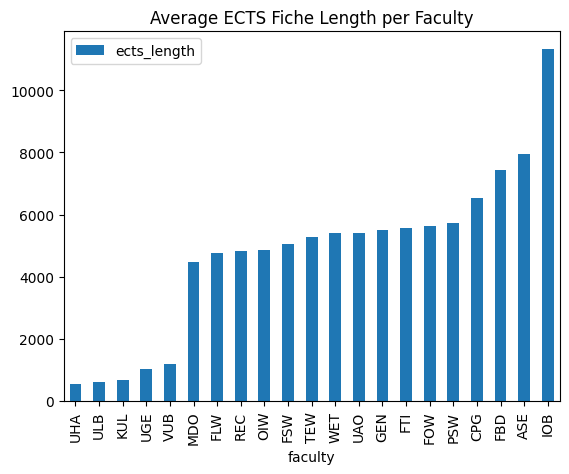

          ects_length
faculty              
UHA        543.000000
ULB        601.000000
KUL        679.500000
UGE       1017.290323
VUB       1179.282051
MDO       4475.095238
FLW       4771.141732
REC       4829.600000
OIW       4872.500000
FSW       5065.900000
TEW       5277.469751
WET       5413.098712
UAO       5414.000000
GEN       5505.204188
FTI       5576.602941
FOW       5619.924399
PSW       5742.109091
CPG       6547.333333
FBD       7443.845411
ASE       7949.500000
IOB      11323.000000



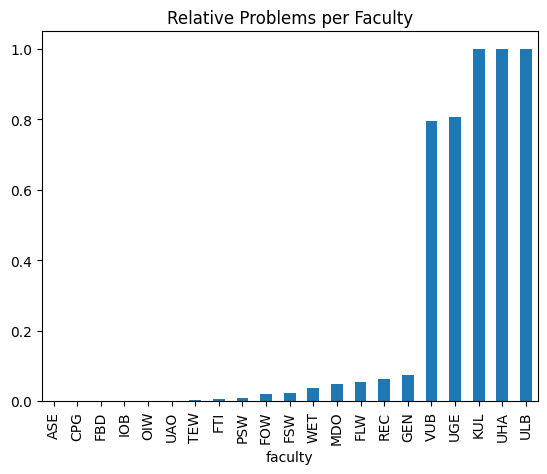

faculty
ASE    0.000000
CPG    0.000000
FBD    0.000000
IOB    0.000000
OIW    0.000000
UAO    0.000000
TEW    0.003559
FTI    0.004902
PSW    0.009091
FOW    0.020619
FSW    0.022222
WET    0.036481
MDO    0.047619
FLW    0.055118
REC    0.063158
GEN    0.073298
VUB    0.794872
UGE    0.806452
KUL    1.000000
UHA    1.000000
ULB    1.000000
Name: problem, dtype: float64


In [40]:

# Maak een grafiekje met de gemiddelde ects fiche lengt per faculteit
df_graph = df[["faculty", "ects_length"]]
df_graph = df_graph.groupby("faculty").mean()
df_graph.sort_values(by="ects_length", inplace=True)
df_graph.plot(kind="bar", title="Average ECTS Fiche Length per Faculty")
plt.show()
print(df_graph)
print()

# Make a graph with relative frequencies of problems per faculty
relative_problems_per_faculty = df.groupby("faculty")["problem"].mean()
relative_problems_per_faculty.sort_values(inplace=True)
relative_problems_per_faculty.plot(kind="bar", title="Relative Problems per Faculty")
plt.show()
print(relative_problems_per_faculty)

#### example get course info ####
# get_courses_info([{"href": "?id=2022-1071FOWARC&lang=nl"}])
####


#### example get ects section ####
# url_params = "?id=2022-1001WETCHE"
# html = requests.get(f"https://www.uantwerpen.be/ajax/courseInfo{url_params}").text
# parsed_html = BeautifulSoup(html, features="lxml")
# print(get_ects_section(parsed_html, 6))
####

# pprint(get_courses("https://www.uantwerpen.be/nl/studeren/aanbod/alle-opleidingen/rechten-studeren/master/studieprogramma/master-in-de-rechten/"))
